In [17]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install yahooquery

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [20]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [21]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [22]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [23]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    
    
    frames =  [macd, signal, hist]
    
    
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
final_text=""
Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-30:].mean() ,6 )
    print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-30:].mean() ,6 )
    print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
#---------------------------------------------------------------------------
#mail2me_v2(df_tmp_f,"Crypto Bollinger bands",final_text)

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-02,BTC-USD,16688.470703,16753.113992,16497.091924,-127.867857,-123.500449,Sell
2023-01-03,BTC-USD,16679.857422,16732.028632,16507.515453,-120.662446,-122.932848,Buy
2023-01-04,BTC-USD,16863.238281,16863.943938,16464.361865,-99.013438,-118.148966,Buy
2023-01-05,BTC-USD,16836.736328,16928.264461,16455.582637,-83.037722,-111.126717,Buy
2023-01-06,BTC-USD,16951.96875,17031.650841,16452.019918,-60.382506,-100.977875,Buy
2023-01-07,BTC-USD,16955.078125,17070.816303,16529.306464,-41.696532,-89.121606,Buy
2023-01-09,BTC-USD,17190.708984,17233.23301,16528.498017,-7.784586,-72.854202,Buy


Bol_Up__Mean_for_last_7days   : 17313.15318
Bol_Down__Mean_for_last_7days : 16496.858892
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-02,ETH-USD,1214.656616,1219.733435,1184.837575,-12.184809,-13.308702,Buy
2023-01-03,ETH-USD,1214.778809,1220.859373,1184.279403,-10.830525,-12.813066,Buy
2023-01-04,ETH-USD,1256.526611,1253.886719,1170.263637,-6.315742,-11.513601,Buy
2023-01-05,ETH-USD,1250.438599,1268.337154,1169.76842,-3.192198,-9.849321,Buy
2023-01-06,ETH-USD,1269.379028,1287.271007,1170.876349,0.802319,-7.718993,Buy
2023-01-07,ETH-USD,1264.270386,1294.243452,1183.189375,3.515255,-5.472143,Buy
2023-01-09,ETH-USD,1320.906372,1328.421562,1183.280272,10.118686,-2.353977,Buy


Bol_Up__Mean_for_last_7days   : 1280.679209
Bol_Down__Mean_for_last_7days : 1179.360978
ALGO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ALGO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-02,ALGO-USD,0.181194,0.183311,0.160362,-0.01453,-0.018294,Buy
2023-01-03,ALGO-USD,0.184302,0.188491,0.159274,-0.012781,-0.017192,Buy
2023-01-04,ALGO-USD,0.187093,0.19293,0.160508,-0.011043,-0.015962,Buy
2023-01-05,ALGO-USD,0.183544,0.192478,0.166215,-0.009839,-0.014737,Buy
2023-01-06,ALGO-USD,0.189497,0.19367,0.170877,-0.008308,-0.013451,Buy
2023-01-07,ALGO-USD,0.194386,0.19648,0.174229,-0.006624,-0.012086,Buy
2023-01-09,ALGO-USD,0.20056,0.202278,0.175029,-0.004737,-0.010616,Buy


Bol_Up__Mean_for_last_7days   : 0.205051
Bol_Down__Mean_for_last_7days : 0.175844
SOL-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
SOL-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-02,SOL-USD,11.272967,11.552389,8.901746,-1.067644,-1.131336,Buy
2023-01-03,SOL-USD,13.344046,13.243512,7.855942,-0.788554,-1.062779,Buy
2023-01-04,SOL-USD,13.435113,14.406616,7.74404,-0.553643,-0.960952,Buy
2023-01-05,SOL-USD,13.41933,15.085946,8.141152,-0.364546,-0.841671,Buy
2023-01-06,SOL-USD,13.525842,15.48497,8.783747,-0.203742,-0.714085,Buy
2023-01-07,SOL-USD,13.092268,15.366578,9.796776,-0.110021,-0.593272,Buy
2023-01-09,SOL-USD,16.256718,16.394402,10.561679,0.217096,-0.431199,Buy


Bol_Up__Mean_for_last_7days   : 13.698653
Bol_Down__Mean_for_last_7days : 10.761092
LUNC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
LUNC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-02,LUNC-USD,0.00016,0.000171,0.000134,-0.000004,-0.000007,Buy
2023-01-03,LUNC-USD,0.000156,0.000157,0.000144,-0.000003,-0.000006,Buy
2023-01-04,LUNC-USD,0.000158,0.00016,0.000143,-0.000003,-0.000005,Buy
2023-01-05,LUNC-USD,0.000152,0.00016,0.000144,-0.000003,-0.000005,Buy
2023-01-06,LUNC-USD,0.000156,0.000157,0.000151,-0.000002,-0.000004,Buy
2023-01-07,LUNC-USD,0.000153,0.000155,0.000155,-0.000002,-0.000004,Buy
2023-01-09,LUNC-USD,0.000168,0.000162,0.000153,-0.000001,-0.000003,Buy


Bol_Up__Mean_for_last_7days   : 0.000166
Bol_Down__Mean_for_last_7days : 0.000141
ROSE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ROSE-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-02,ROSE-USD,0.035778,0.036751,0.033291,-0.002422,-0.002759,Buy
2023-01-03,ROSE-USD,0.035716,0.036485,0.033417,-0.002237,-0.002654,Buy
2023-01-04,ROSE-USD,0.036692,0.037089,0.033113,-0.001988,-0.002521,Buy
2023-01-05,ROSE-USD,0.036241,0.037427,0.033259,-0.001807,-0.002378,Buy
2023-01-06,ROSE-USD,0.037146,0.037855,0.033746,-0.001573,-0.002217,Buy
2023-01-07,ROSE-USD,0.037152,0.037912,0.034539,-0.00137,-0.002048,Buy
2023-01-09,ROSE-USD,0.040001,0.039888,0.034034,-0.000969,-0.001832,Buy


Bol_Up__Mean_for_last_7days   : 0.041057
Bol_Down__Mean_for_last_7days : 0.03562
SHIB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
SHIB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-02,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2023-01-03,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2023-01-04,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2023-01-05,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2023-01-06,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2023-01-07,SHIB-USD,0.000008,0.000008,0.000008,-0.0,-0.0,Buy
2023-01-09,SHIB-USD,0.000009,0.000009,0.000008,-0.0,-0.0,Buy


Bol_Up__Mean_for_last_7days   : 9e-06
Bol_Down__Mean_for_last_7days : 8e-06
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-02,XRP-USD,0.348556,0.369547,0.32753,-0.009945,-0.010281,Buy
2023-01-03,XRP-USD,0.343824,0.357073,0.333061,-0.009709,-0.010167,Buy
2023-01-04,XRP-USD,0.347794,0.351181,0.336456,-0.009098,-0.009953,Buy
2023-01-05,XRP-USD,0.338039,0.351714,0.33455,-0.009293,-0.009821,Buy
2023-01-06,XRP-USD,0.344645,0.35161,0.334547,-0.008813,-0.009619,Buy
2023-01-07,XRP-USD,0.344268,0.351781,0.335616,-0.008367,-0.009369,Buy
2023-01-09,XRP-USD,0.348878,0.352709,0.337578,-0.007554,-0.009006,Buy


Bol_Up__Mean_for_last_7days   : 0.377361
Bol_Down__Mean_for_last_7days : 0.343764
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-02,ADA-USD,0.253828,0.261075,0.238499,-0.014978,-0.016326,Buy
2023-01-03,ADA-USD,0.252796,0.256008,0.241403,-0.014077,-0.015876,Buy
2023-01-04,ADA-USD,0.267677,0.267516,0.235408,-0.012023,-0.015106,Buy
2023-01-05,ADA-USD,0.269102,0.274266,0.23579,-0.010163,-0.014117,Buy
2023-01-06,ADA-USD,0.278652,0.283798,0.235714,-0.007828,-0.012859,Buy
2023-01-07,ADA-USD,0.277105,0.28804,0.240226,-0.006033,-0.011494,Buy
2023-01-09,ADA-USD,0.31656,0.316588,0.23076,-0.00141,-0.009477,Buy


Bol_Up__Mean_for_last_7days   : 0.292404
Bol_Down__Mean_for_last_7days : 0.254796


In [24]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [30]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

dfx=getRatesTable(*Crypto_Pairs)

#dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



[*********************100%***********************]  1 of 1 completed
XRP-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ADA-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 3mo 1

In [26]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


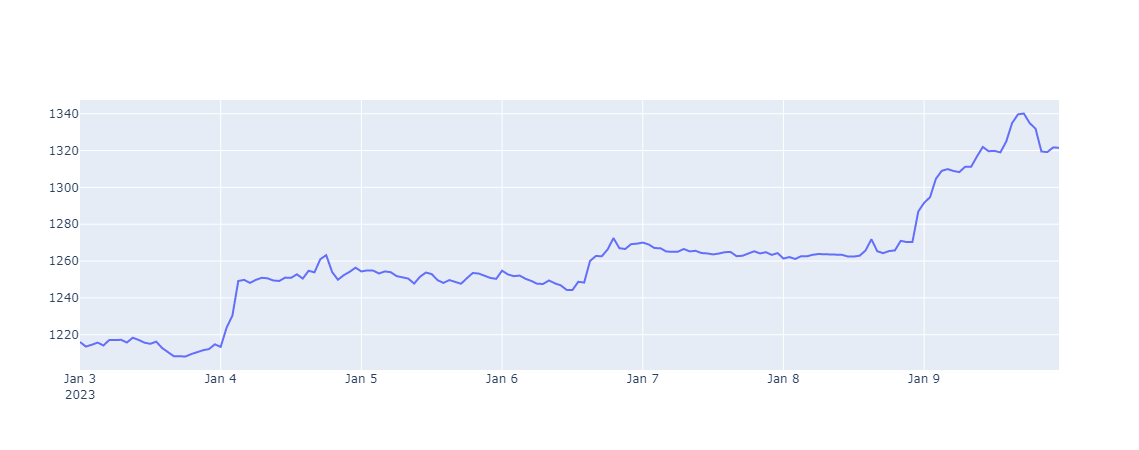

In [31]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    
#------------------------------------------------

#( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
#( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
#( getLine(getRates('ETH-USD',  '3y',  '1d')) )

In [28]:

html = dfx.to_html()
# Write the HTML to a file
with open('crypto_change.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,3658.8958,17.7817,118.1819,-58.9834,-11.5971,0.3325,3.0094,0.1584
1,ETH-USD,311.6461,1.6285,850.4346,-58.1694,-0.1059,4.4944,8.7491,2.2765
2,ALGO-USD,-93.7344,-93.7344,-10.6596,-85.6931,-40.7746,-11.1212,10.6943,-1.1073
3,SOL-USD,1610.0620,1610.0620,1610.0620,-88.4523,-50.5868,19.7655,44.2807,9.1605
4,LUNC-USD,-99.9872,-99.9872,-99.9188,-99.9998,-38.2353,-2.3256,5.0000,6.3291
5,ROSE-USD,4.7491,4.7491,4.7491,-88.1751,-32.3419,-9.9825,11.8219,0.5579
6,SHIB-USD,inf,inf,inf,-67.8571,-18.1818,0.0000,12.5000,0.0000
7,XRP-USD,60.4245,-83.3996,70.2810,-53.7572,-34.6747,-10.3450,0.1024,1.0235
8,ADA-USD,887.7297,-61.1415,770.7528,-73.0294,-25.1673,1.5867,24.7250,3.7462


In [29]:
html = df_tmp_f.to_html()
# Write the HTML to a file
with open('crypto_bol.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-02,BTC-USD,16688.470703,16753.113992,16497.091924,-127.867857,-123.500449,Sell
2023-01-03,BTC-USD,16679.857422,16732.028632,16507.515453,-120.662446,-122.932848,Buy
2023-01-04,BTC-USD,16863.238281,16863.943938,16464.361865,-99.013438,-118.148966,Buy
2023-01-05,BTC-USD,16836.736328,16928.264461,16455.582637,-83.037722,-111.126717,Buy
2023-01-06,BTC-USD,16951.96875,17031.650841,16452.019918,-60.382506,-100.977875,Buy
2023-01-07,BTC-USD,16955.078125,17070.816303,16529.306464,-41.696532,-89.121606,Buy
2023-01-09,BTC-USD,17190.708984,17233.23301,16528.498017,-7.784586,-72.854202,Buy
2023-01-02,ETH-USD,1214.656616,1219.733435,1184.837575,-12.184809,-13.308702,Buy
2023-01-03,ETH-USD,1214.778809,1220.859373,1184.279403,-10.830525,-12.813066,Buy
